In [3]:
import numpy as np     
import pandas as pd    
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# load the dataset containing normalized text as well as the additional features obtained from notebook 1

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train_clean_add_feat.csv', index_col = False)

df_train.head()

,text,target,text_norm,stemmed_keyword,disaster_asc_coeff,length_norm,neg,neu,pos
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak,0.785714,41,0.000,1.000,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire,0.386364,36,0.286,0.714,0.0
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu,0.767241,69,0.000,1.000,0.0
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu,0.767241,49,0.000,1.000,0.0
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire,0.386364,52,0.000,1.000,0.0


In [5]:
# In this part we will compare results using the original text with minimum processing vs the normalized text 
df_orig = df_train[['text', 'target']]
df_norm = df_train[['text_norm', 'target']]

## 1) Training with Normalized Text Data
For this text data, stop words, symbols, urls and punctuations have been removed. In addition, the words have also been stemmed. This means that the vocabulariy will be smaller; however, any contextual information provided by stop words will be lost.

In [6]:
from tensorflow.keras.preprocessingcessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer()

In [12]:
tokenizer.fit_on_texts(df_norm['text_norm'])

In [14]:
tokenizer.texts_to_sequences(df_norm['text_norm'][0])

[[],
 [1179],
 [1179],
 [],
 [],
 [857],
 [1179],
 [],
 [],
 [],
 [600],
 [],
 [1179],
 [],
 [857],
 [],
 [2014],
 [5121],
 [103],
 [],
 [11038],
 [],
 [],
 [],
 [],
 [],
 [],
 [2569],
 [2569],
 [],
 [2014],
 [],
 [1344],
 [],
 [857],
 [1941],
 [],
 [1257],
 [],
 [103],
 []]

In [16]:
# get max length to pad sequences and abd vocab size
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAX_LENGTH = max([len(text.split()) for text in df_norm['text_norm']])
print(f'Vocab size: {VOCAB_SIZE}')
print(f'Max sequence length: {MAX_LENGTH}')

Vocab size: 19542
Max sequence length: 25


In [17]:
# we will set embedding dimension to be 100
EMBEDDING_DIM = 100

### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = df_norm['text_norm']
y = df_norm['target']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [21]:
X_train.head()

5797    accionempresa chinaûª stock market crash summ...
3232    feel engulf low selfimag take quiz httptcoykvs...
5145    mccainenl think spectacular look stonewal riot...
4911    magic citi mayhem kissimme adventur aug 5 2015...
253     us nation park servic tonto nation forest stop...
Name: text_norm, dtype: object

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# tokenize text data
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [26]:
# apply padding
X_train_pad = pad_sequences(X_train_tokens, maxlen = MAX_LENGTH, padding = 'post')
X_test_pad = pad_sequences(X_test_tokens, maxlen = MAX_LENGTH, padding = 'post')

In [28]:
print(type(X_train_pad))
print(X_train_pad.shape)

<class 'numpy.ndarray'>
(5087, 25)


In [29]:
X_train_pad[0]

array([ 3513,  1891,   373,   272,    20,   296,  1200,   692,  2174,
        1249, 16453,  3514,  3515,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

### Building The Model
Since the goal is to train a binary classification model, the RNN architecture will be many-to-one.

In [30]:
# basic architecture from tensorflow classiication with RNN documentation
import tensorflow as tf

In [37]:
model = tf.keras.Sequential()

In [38]:
model.add(tf.keras.layers.Embedding(
        input_dim =VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           1954200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,047,001
Trainable params: 2,047,001
Non-trainable params: 0
_________________________________________________________________


In [40]:
# compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [54]:
history = model.fit(X_train_pad, y_train, batch_size = 32, epochs = 15,
                    validation_split = 0.25)

Epoch 1/15
120/120 [==============================] - 82s 676ms/step - loss: 0.0489 - accuracy: 0.9882 - val_loss: 1.2512 - val_accuracy: 0.7736
Epoch 2/15
120/120 [==============================] - 89s 749ms/step - loss: 0.0364 - accuracy: 0.9919 - val_loss: 1.3755 - val_accuracy: 0.7634
Epoch 3/15
120/120 [==============================] - 66s 554ms/step - loss: 0.0327 - accuracy: 0.9932 - val_loss: 1.4495 - val_accuracy: 0.7642
Epoch 4/15
120/120 [==============================] - 145s 1s/step - loss: 0.0277 - accuracy: 0.9940 - val_loss: 1.5517 - val_accuracy: 0.7579
Epoch 5/15
120/120 [==============================] - 123s 1s/step - loss: 0.0222 - accuracy: 0.9955 - val_loss: 1.5888 - val_accuracy: 0.7610
Epoch 6/15
120/120 [==============================] - 104s 856ms/step - loss: 0.0214 - accuracy: 0.9958 - val_loss: 1.6453 - val_accuracy: 0.7594
Epoch 7/15
120/120 [==============================] - 104s 875ms/step - loss: 0.0173 - accuracy: 0.9966 - val_loss: 1.7276 - val_accu

In [55]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 2.1754456965252755)

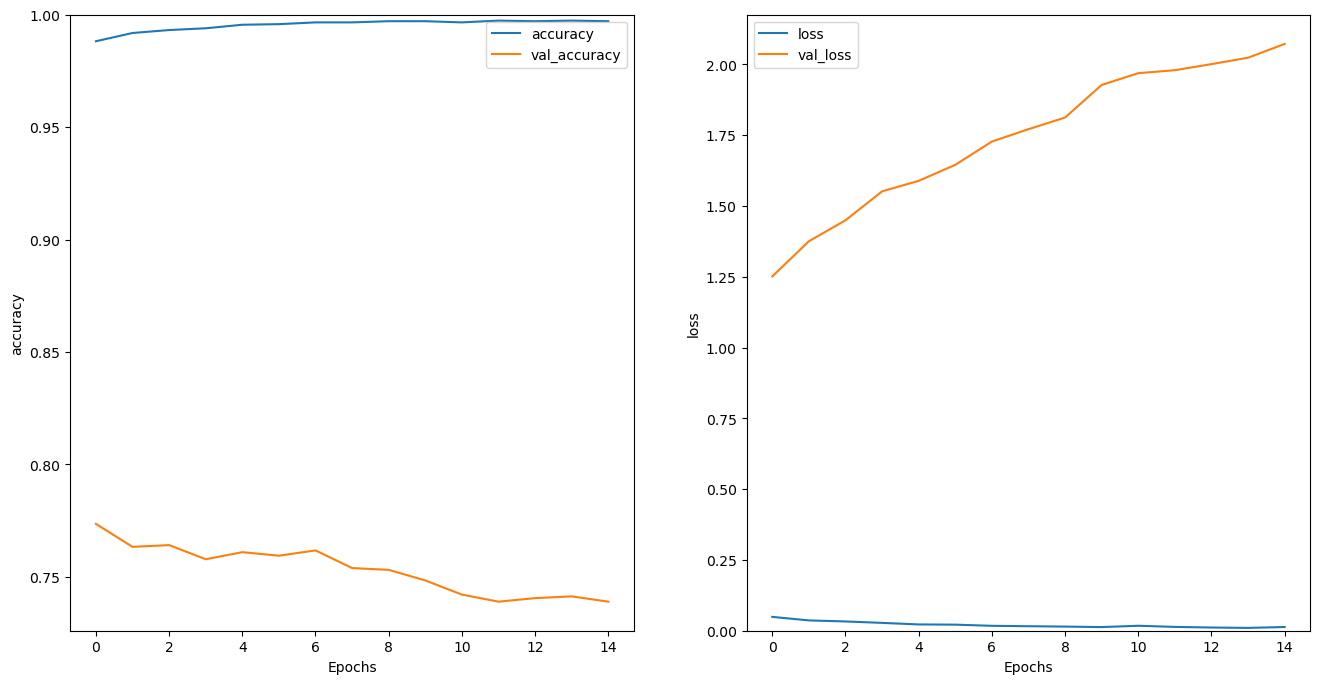

In [56]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [52]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)

79/79 [==============================] - 14s 171ms/step - loss: 1.1819 - accuracy: 0.7622


In [53]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 1.1819095611572266
Test Accuracy: 0.7621707916259766
